In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/handwritten-persian-numerals/train.csv
/kaggle/input/handwritten-persian-numerals/test.csv


# **1- Importing Required Libraries**

In [2]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from  torch.distributions.multivariate_normal import MultivariateNormal
import torch.nn.functional as F
from torch.optim import lr_scheduler
from tqdm import tqdm
from IPython import display

import torchvision.utils as vutils
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from torchvision.transforms import ToPILImage


import os
from os import listdir
from pathlib import Path
import imghdr

# **2- Loading Handwritten Persian numerals dataset**

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data.iloc[idx, 1:].values.astype('float32').reshape(1,28, 28)

        if self.transform:
            image = self.transform(image)

        return image

In [4]:
dataset = MNISTDataset('/kaggle/input/handwritten-persian-numerals/train.csv')

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Using DataLoader
<hr style="color: red;">
</font>
</div>

In [5]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
real_batch = next(iter(dataloader))
real_batch.shape

torch.Size([64, 1, 28, 28])

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Visualizing the Data
<hr style="color: red;">
</font>
</div>

In [8]:
# plot batch of images
def plot_image_batch(my_batch):

  fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(10, 10))
  img_num=-1
  for i in range(8):
      for j in range(8):
          ax = axes[i][j]
          img_num+=1
  
          ax.imshow(np.transpose(vutils.make_grid(my_batch[img_num].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
  plt.show()

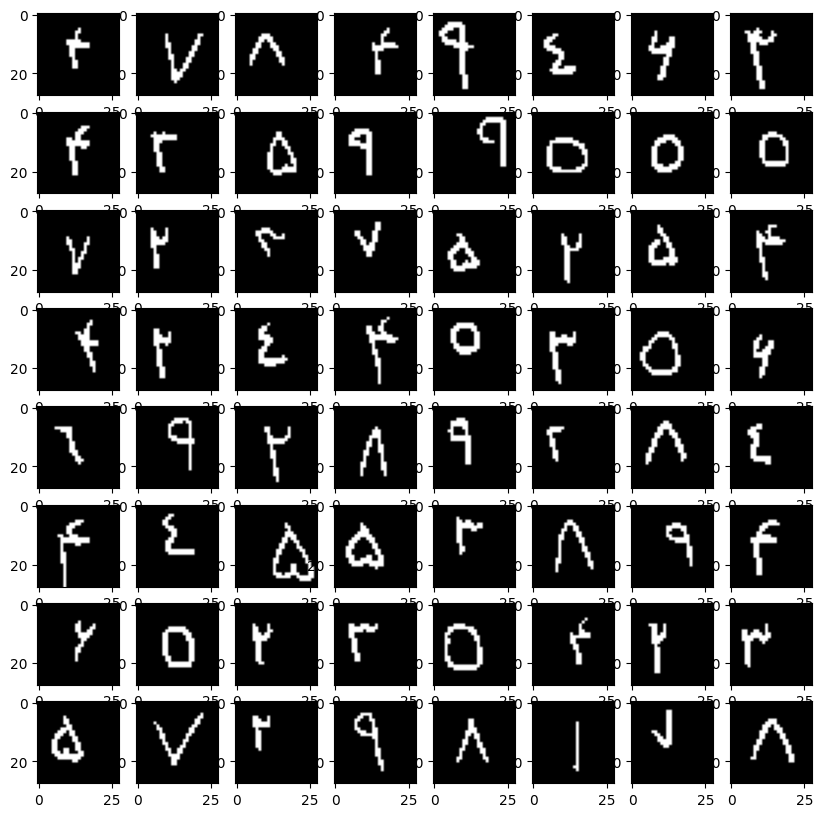

In [9]:
plot_image_batch(real_batch)

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Noise Generation
<hr style="color: red;">
</font>
</div>

In [10]:
def random_noise_generator(batch_size, dim):
    return torch.rand(batch_size, dim)*2 - 1

# **3- Generator and Discriminator (for DCGANs)**

## **3-1- Building the Generator** 

In [11]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 256*7*7)
        self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.trans_conv1_bn = nn.BatchNorm2d(128)
        self.relu1 = nn.ReLU(True)
        self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv2_bn = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(True)
        self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
        self.trans_conv3_bn = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU(True)
        self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = self.trans_conv1(x)
        x = self.trans_conv1_bn(x)
        x = self.relu1(x)
        x = self.trans_conv2(x)
        x = self.trans_conv2_bn(x)
        x = self.relu2(x)
        x = self.trans_conv3(x)
        x = self.trans_conv3_bn(x)
        x = self.relu3(x)
        x = self.trans_conv4(x)
        x = self.tanh(x)
        
        return x 

## **3-2- Building the Discriminator** 

In [12]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
        self.conv0_bn = nn.BatchNorm2d(32)
        self.conv0_drop = nn.Dropout2d(0.25)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.leaky_relu3 = nn.LeakyReLU(0.2, inplace=True)
        
        self.fc = nn.Linear(12544, 1)
    
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = self.conv0_drop(x)
        x = self.leaky_relu1(x)
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = self.leaky_relu2(x)
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = self.leaky_relu2(x)
        x = self.conv3(x)
        x = self.conv3_bn(x)
        x = self.leaky_relu2(x)
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [13]:
#Comment the following 2 lines if you want to run the Basic GAN instead of the DCGAN
D = Discriminator()
G = Generator()

#Sanity check of the model instances
print(D)
print(G)

#Passing to the GPU
D = D.to(device)
G = G.to(device)

D = D.float()
G = G.float()

Discriminator(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv0_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv0_drop): Dropout2d(p=0.25, inplace=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2, inplace=True)
  (fc): Linear(in_features=12544, out_features=1, bias=True)
)
Ge

## **3-3- Defining Loss Functions** 

In [14]:
Loss = nn.BCEWithLogitsLoss()
def discriminator_real_loss(real_out):
    real_label = torch.ones(real_out.size()[0], 1).to(device)
    real_loss = Loss(real_out.squeeze(), real_label.squeeze())
    return real_loss

def discriminator_fake_loss(fake_out):
    fake_label = torch.zeros(fake_out.size()[0], 1).to(device)
    fake_loss = Loss(fake_out.squeeze(), fake_label.squeeze())
    return fake_loss

def discriminator_loss(real_out, fake_out):
    real_loss = discriminator_real_loss(real_out)
    fake_loss = discriminator_fake_loss(fake_out)
    total_loss = (real_loss + fake_loss)
    return total_loss

In [15]:
def generator_loss(gen_disc_out):
    label = torch.ones(gen_disc_out.size()[0], 1).to(device)
    gen_loss = Loss(gen_disc_out.squeeze(), label.squeeze())
    return gen_loss

## **3-4- Defining Optimizers** 

In [16]:
learning_rate = 0.0002
gen_opt = optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5, 0.999))
disc_opt = optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5, 0.999))

# **4- Training DCGANs**

In [17]:
def train(D, G, disc_opt, gen_opt, train_dl, batch_size = 32, epochs = 120, gen_input_size = 100):
    
    disc_losses = []
    gen_losses = []
    
    #Having a fixed sample to monitor the progress of the generator
    sample_size = 16
    fixed_samples = random_noise_generator(sample_size, gen_input_size)
    fixed_samples = fixed_samples.to(device)
    
    #Going into training mode
    D.train()
    G.train()
    
    for epoch in range(epochs + 1):
        
        disc_loss_total = 0
        gen_loss_total = 0
        gen_out = 0
        
        for train_x in train_dl:
            
            #Discriminator training
            disc_opt.zero_grad()
            
            train_x = train_x*2 - 1          #Converting the real images to have values between -1 and 1
            train_x = train_x.to(device)     #Passing to GPU
            real_out = D(train_x.float())    
            
            disc_gen_in = random_noise_generator(batch_size, gen_input_size)
            disc_gen_in = disc_gen_in.to(device)   #Passing to GPU
            
            disc_gen_out = G(disc_gen_in.float()).detach()  #Detaching to avoid training the generator
            fake_out = D(disc_gen_out.float())
            
            disc_loss = discriminator_loss(real_out, fake_out)  #Loss calculation
            disc_loss_total += disc_loss
            disc_loss.backward()
            disc_opt.step()  
        
            #Generator training
            gen_opt.zero_grad()
            
            
            gen_out = G(disc_gen_in.float())     #Feeding noise into the generator
            gen_disc_out = D(gen_out.float())       #Passing into the discrminator
            
            gen_loss = generator_loss(gen_disc_out)  #Generator loss calculation
            gen_loss_total += gen_loss
            gen_loss.backward()
            gen_opt.step()
        
        disc_losses.append(disc_loss_total)
        gen_losses.append(gen_loss_total)
        
        #Plotting samples every 5 epochs
        if epoch%5 == 0:
            G.eval()                    #Going into eval mode to get sample images         
            samples = G(fixed_samples.float())
            G.train()                   #Going back into train mode
            
            fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
            for ax, img in zip(axes.flatten(), samples):
               img = img.cpu().detach()
               ax.xaxis.set_visible(False)
               ax.yaxis.set_visible(False)
               im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        
        
        #Printing losses every epoch
        #print("Epoch ", epoch, ": Discriminator Loss = ", disc_loss_total/len(train_dl), ", Generator Loss = ", gen_loss_total/len(train_dl))    
    
    return disc_losses, gen_losses

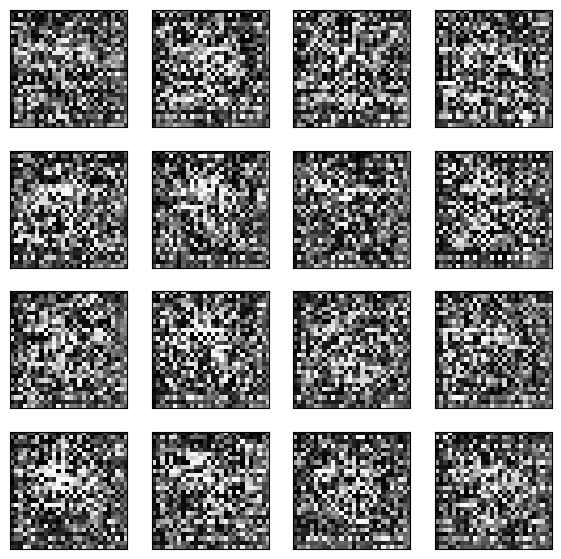

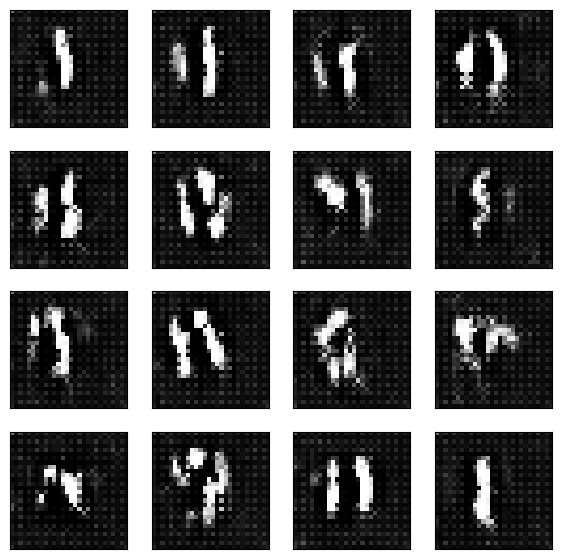

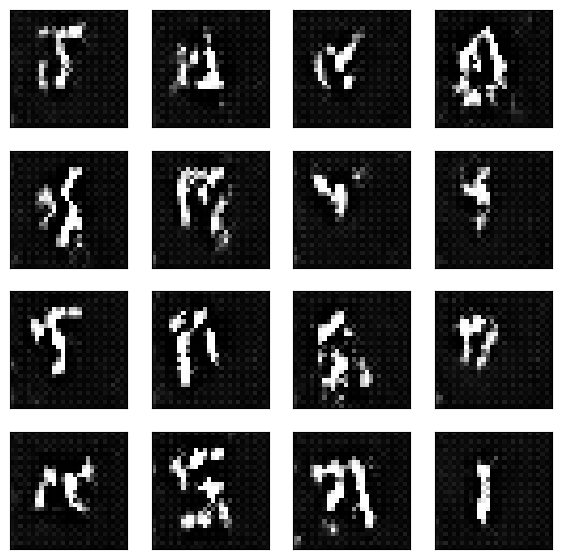

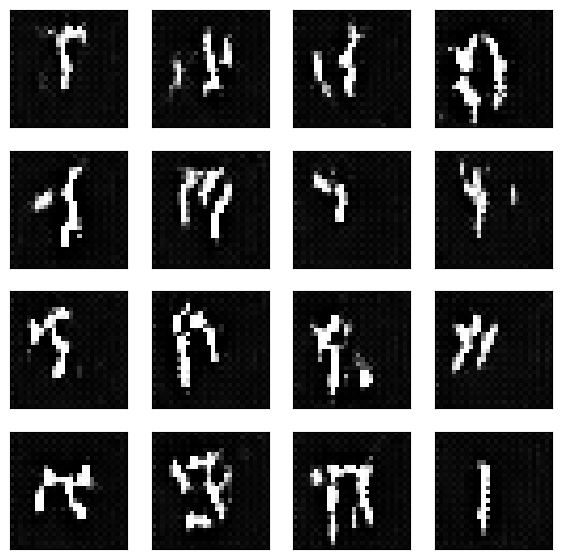

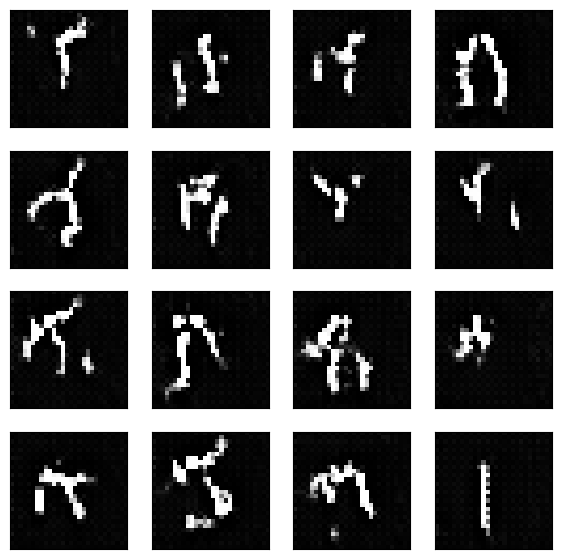

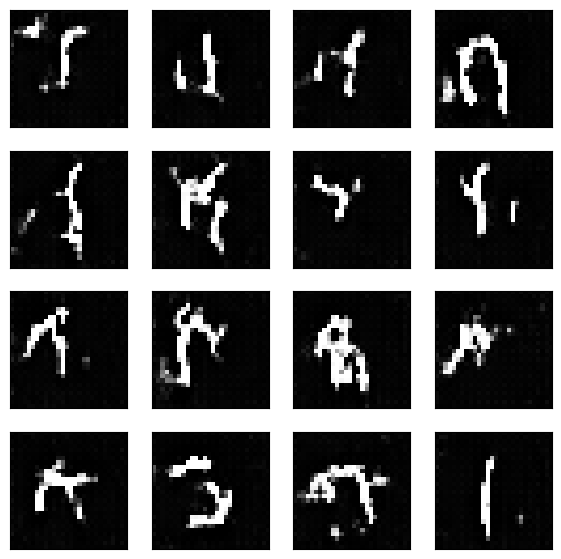

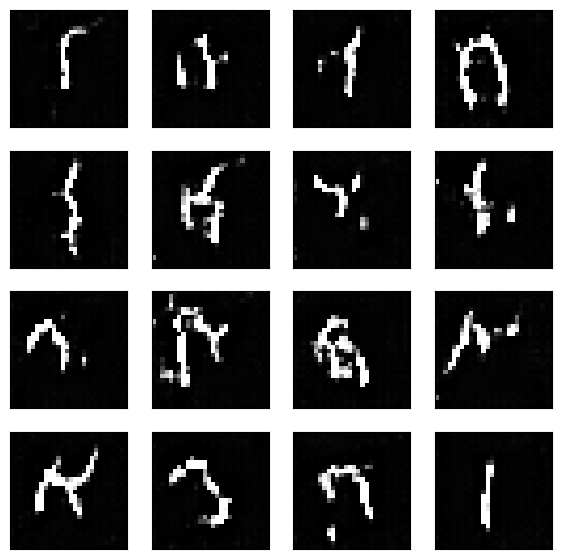

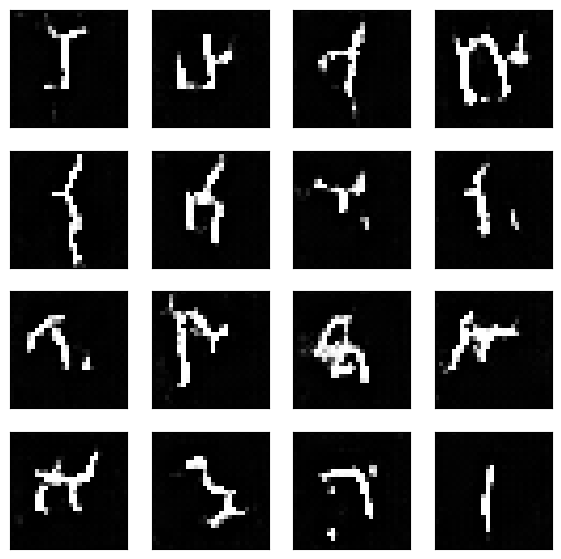

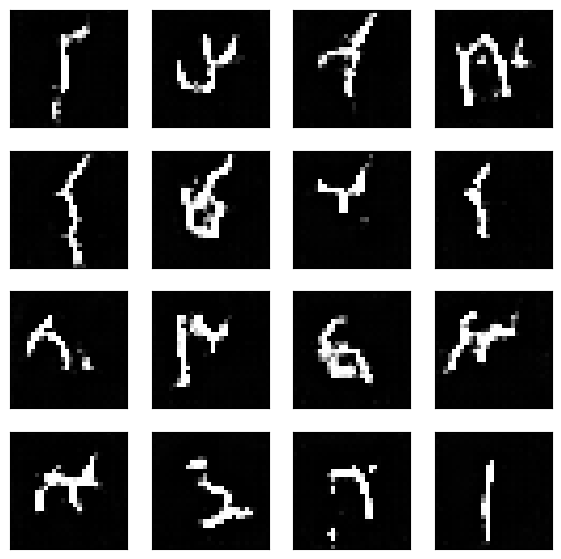

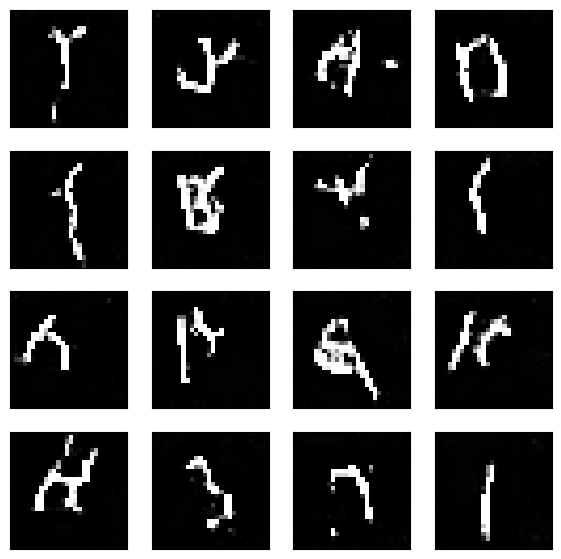

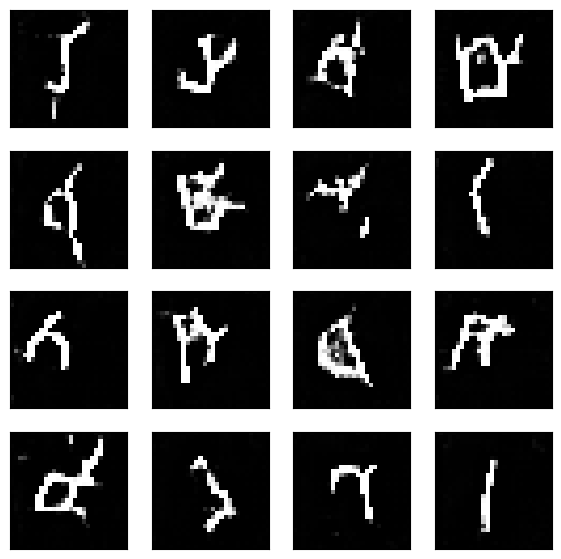

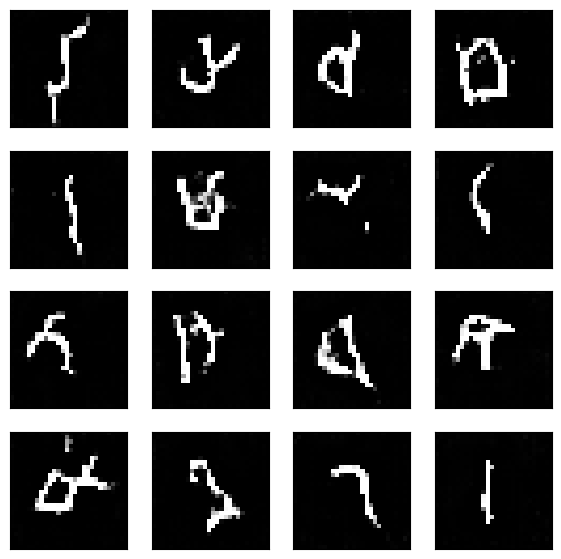

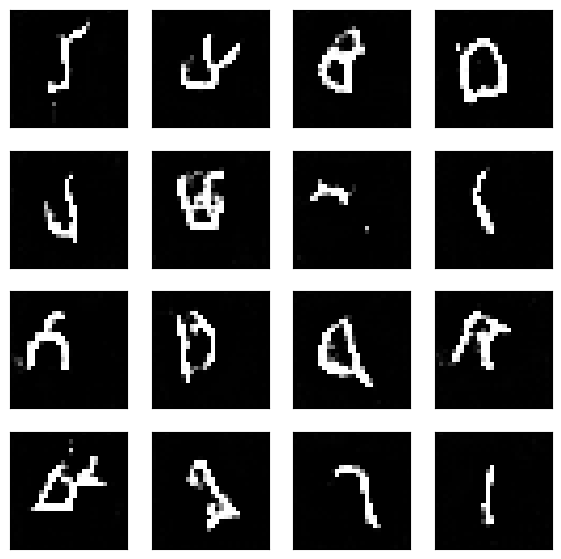

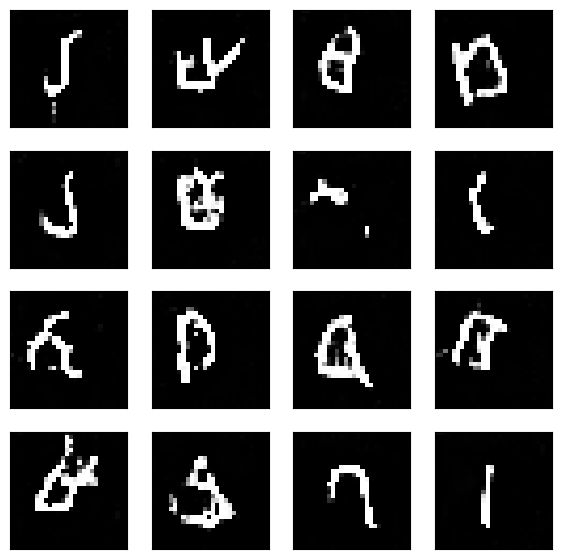

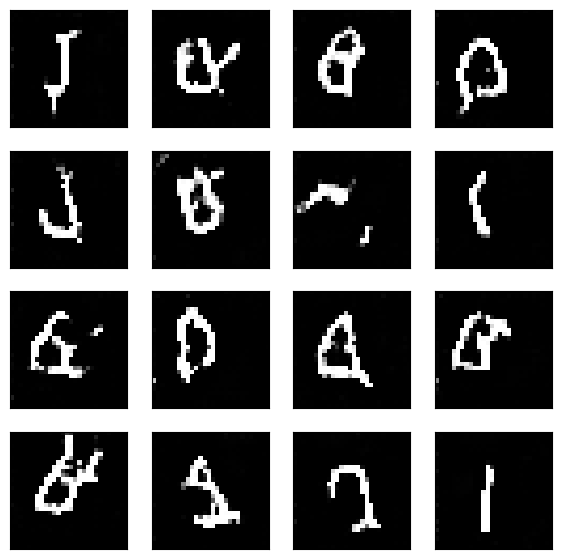

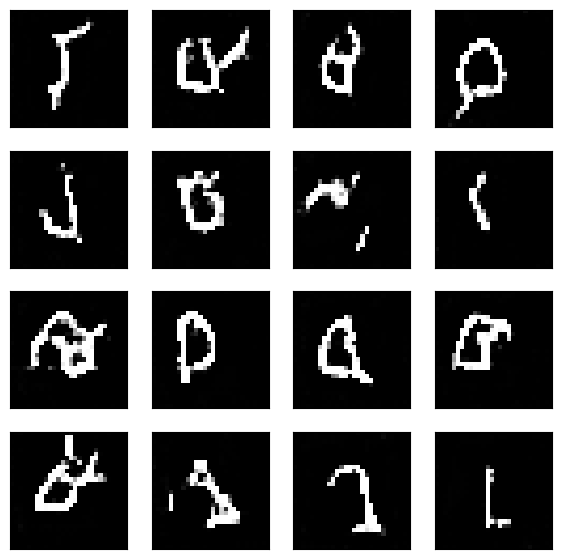

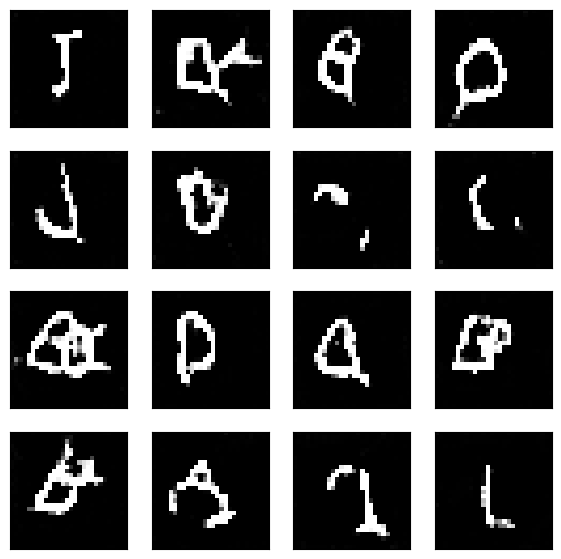

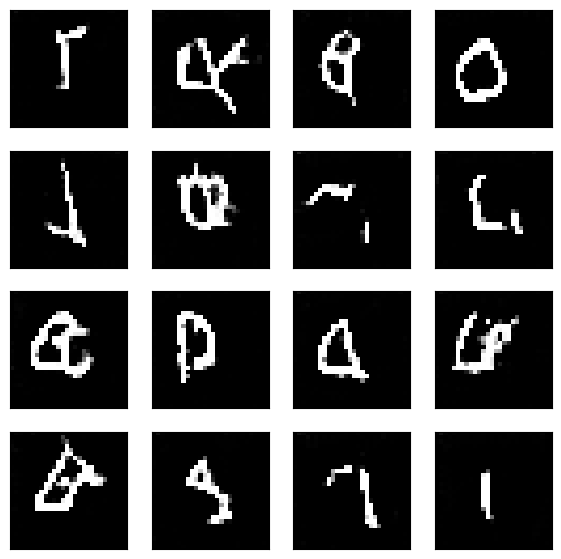

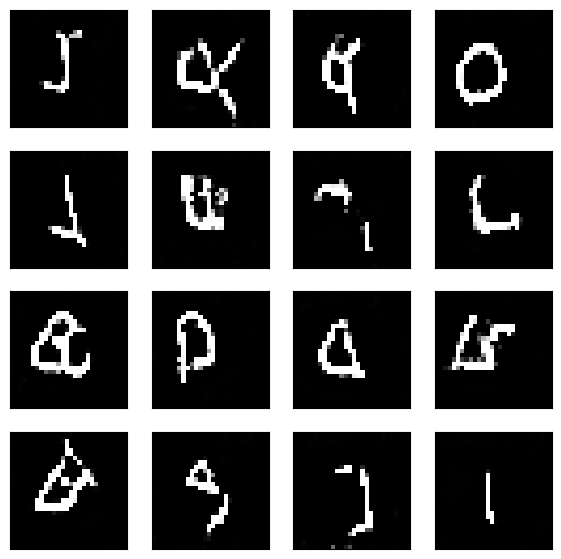

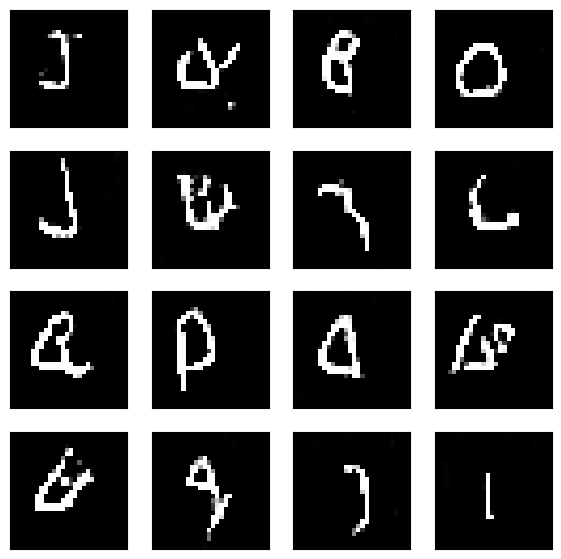

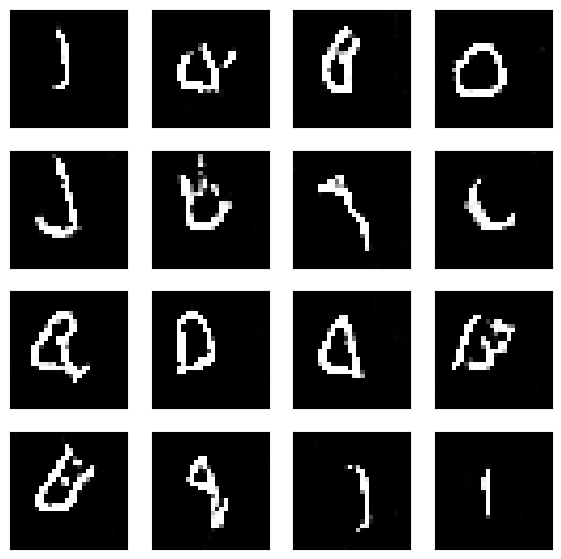

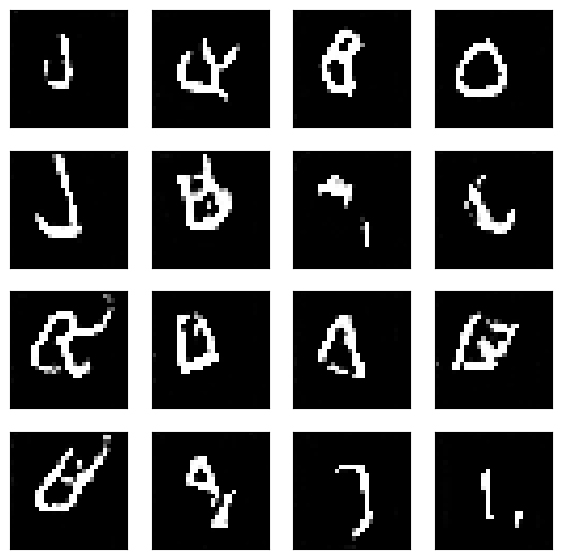

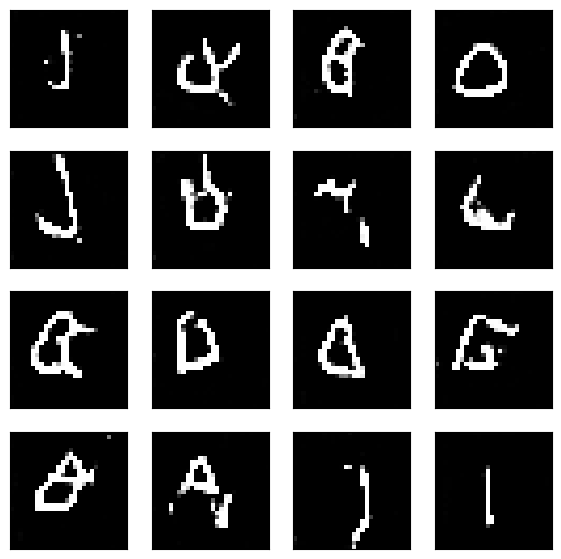

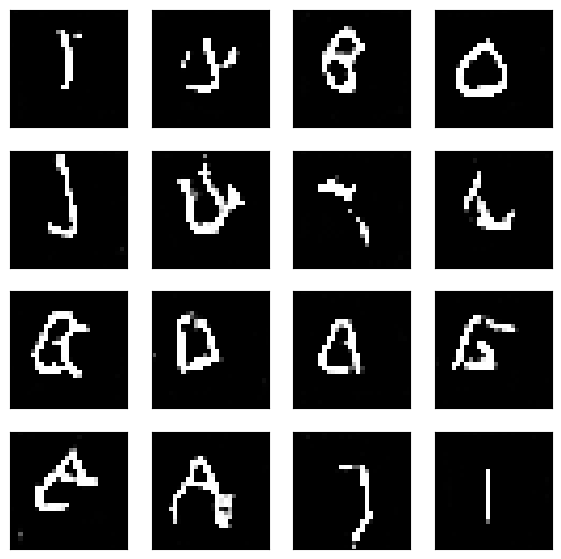

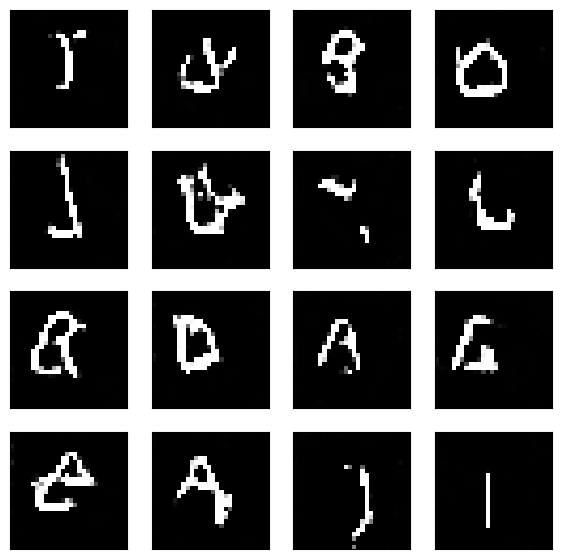

In [18]:
disc_losses, gen_losses = train(D, G, disc_opt, gen_opt, dataloader, batch_size)

<div style="background-color: green; padding: 10px; border-radius: 10px; ">
<font size="4px" color="white">
<hr style="color: red;">
Plotting Losses
<hr style="color: red;">
</font>
</div>

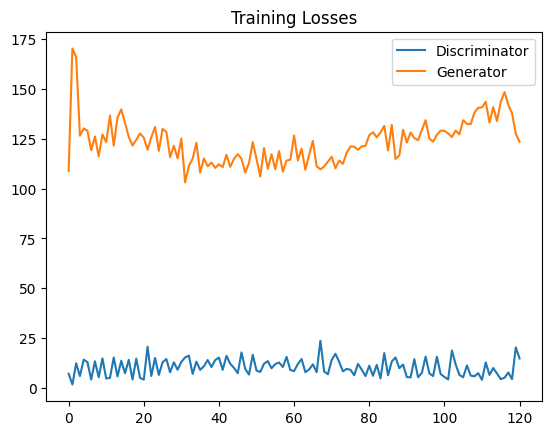

In [19]:
fig, ax = plt.subplots()

disc_losses = torch.tensor(disc_losses, device='cuda')
gen_losses = torch.tensor(gen_losses, device='cuda')

disc_losses = disc_losses.cpu().numpy()
gen_losses = gen_losses.cpu().numpy()

plt.plot(disc_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.title("Training Losses")
plt.legend()